# Statistiques sur les données de recensement de 1832

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from scipy import stats

In [2]:
def get_color_list(cmap, n):
    
    values = np.linspace(0, 1, n)
    colors = cmap(values)
    colors = [color[:3] for color in colors]
    return colors

In [6]:
df = pd.read_excel("data/1832_v4.xlsx", index_col=0)
jobs = pd.read_excel("data/histoire urbaine digitale classification metiers.xlsx", na_values="?", sheet_name="data")

In [7]:
df = df[[
    "nom_rue_norm_2",
    "no_maison",
    "proprietaire_nom_norm_2",
    "chef_prenom_norm",
    "chef_nom_norm_2",
    "chef_annee_naissance",
    "epouse_nom_norm",
    "epouse_annee_naissance",
    "enfants_dans_la_commune_prenom_norm",
    "enfants_annee_naissance",
    "chef_origine_norm_2",
    "chef_annee_arrivee",
    "chef_vocation_norm_2",
    "pensionnaires_prenom_norm",
    "pensionnaires_nom_norm",
    "pensionnaires_origine_norm",
    "Page"
]]

In [8]:
# remove "_norm_2" from all column names
df.columns = [re.sub("_norm_2", "", col) for col in df.columns]
# remove "_norm" from all column names
df.columns = [re.sub("_norm", "", col) for col in df.columns]

In [9]:
df.columns

Index(['nom_rue', 'no_maison', 'proprietaire_nom', 'chef_prenom', 'chef_nom',
       'chef_annee_naissance', 'epouse_nom', 'epouse_annee_naissance',
       'enfants_dans_la_commune_prenom', 'enfants_annee_naissance',
       'chef_origine', 'chef_annee_arrivee', 'chef_vocation',
       'pensionnaires_prenom', 'pensionnaires_nom', 'pensionnaires_origine',
       'Page'],
      dtype='object')

In [12]:
# Join df and jobs with chef_vocation in df and JOB in jobs
df = df.join(jobs.set_index("JOB"), on="chef_vocation", how="left")
# rename the CLASS column as chef_vocation_class
df = df.rename(columns={"CLASS": "chef_vocation_class"})

In [13]:
df[["chef_vocation", "chef_vocation_class"]]

,chef_vocation,chef_vocation_class
1,charon,NaN
2,marechal-ferrant,artisanat
3,lingere,service
4,rentier,rente
5,garcon voiturier,NaN
...,...,...
3697,agriculteur,agricole
3698,journalier,agricole
3699,agriculteur,agricole
3700,agriculteur,agricole


In [14]:
jobs[jobs.JOB == "ministre"]

,JOB,CLASS
40,ministre,administration


In [15]:
df.chef_vocation_class.unique()

array([nan, 'artisanat', 'service', 'rente', 'commerce',
       'artisanat/service', 'agricole', 'construction',
       'artisanat/construction', 'administration',
       'construction/artisanat', 'service/construction',
       'service/artisanat'], dtype=object)

In [16]:
df.columns

Index(['nom_rue', 'no_maison', 'proprietaire_nom', 'chef_prenom', 'chef_nom',
       'chef_annee_naissance', 'epouse_nom', 'epouse_annee_naissance',
       'enfants_dans_la_commune_prenom', 'enfants_annee_naissance',
       'chef_origine', 'chef_annee_arrivee', 'chef_vocation',
       'pensionnaires_prenom', 'pensionnaires_nom', 'pensionnaires_origine',
       'Page', 'chef_vocation_class'],
      dtype='object')

In [17]:
df.shape

(3674, 18)

## Statistiques sur les lieux d'origines des chefs de famille

In [18]:
df.chef_origine.shape

(3674,)

In [67]:
origins = df.groupby("chef_origine").size().sort_values(ascending=False)
# drop the index ·
print(f"Nombre d'indéfini {origins.loc['·']}, cela représente {origins.loc['·']/origins.sum():.2%} des données")
origins = origins.drop("·", axis=0)
origins.head()

Nombre d'indéfini 126, cela représente 3.44% des données


chef_origine
lausanne                 622
lutry                    102
corporation francaise     73
epalinges                 68
villette                  53
dtype: int64

In [69]:
#for i in df.groupby("chef_origine").size().sort_values(ascending=False).index:
#    print(i)

0.34471455886369845

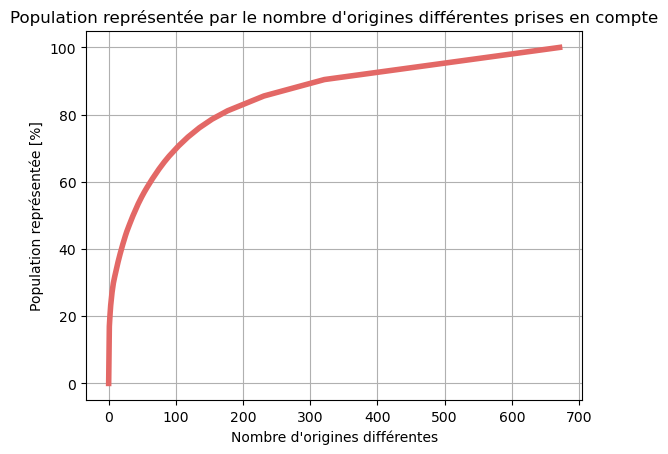

In [20]:
# Get the percentage of the population that is represented by the top 10 origins and plot it as a graph in terms of x
percentages = [origins.head(x).sum() / origins.sum() for x in range(0, len(origins))]
# Plot the above as a line
plt.title("Population représentée par le nombre d'origines différentes prises en compte")
plt.xlabel("Nombre d'origines différentes")
plt.ylabel("Population représentée [%]")
plt.grid(visible=True, which="both")
plt.plot(np.asarray(percentages) * 100,'-',color="#e36866", linewidth=4)
origins.head(12).sum() / origins.sum()

In [21]:
origins[:10].sum()

1197

Nombre d'indéfini 126


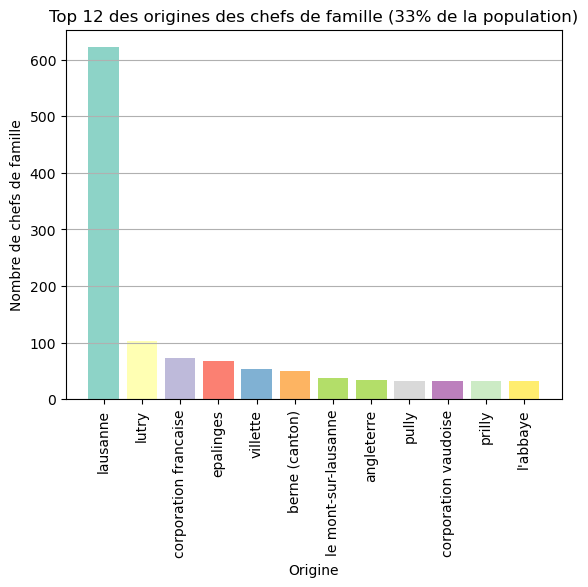

In [22]:

origins_with_others = pd.concat([origins[:12], pd.Series(origins[12:].sum(), index=["Autres"])])
# plot the top 12 origins as a bar chart with the others grouped as "Autres"
plt.title("Top 12 des origines des chefs de famille (33% de la population)")
plt.xlabel("Origine")
plt.ylabel("Nombre de chefs de famille")
# plot only the horizontal grid
plt.grid(visible=True, which="major", axis="y")
plt.bar(origins[:12].index, origins[:12].values, color=get_color_list(plt.cm.Set3, 13))
plt.xticks(rotation=90)
plt.show()

On a enlevé le point parce qu'il ne represente que ???

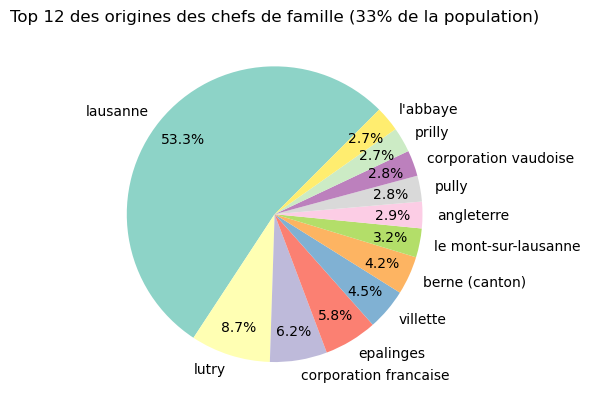

In [23]:
# Make the same plot as above but with the percentage of the population represented by each origin in a pie chart
plt.title("Top 12 des origines des chefs de famille (33% de la population)")
# make the percentages more readable spacing them out$
plt.pie(origins[:12].values, labels=origins[:12].index, autopct="%1.1f%%", colors=get_color_list(plt.cm.Set3, 12), pctdistance=0.8, startangle=45)
plt.show()

In [24]:
# What is the percentage of people comming from Lausanne ?
origins[0] / df.shape[0]

0.1692977681001633

$17\%$ des chefs sont d'origine lausanoises.

## Statistiqus sur l'année de naissance des chefs de familles

Les données ne sont pas propres, on a des choses bizarres dans toutes les colonnes. Pour ce faire, on essaie de prendre des données qui semblent propres.

On ne prend que les années de naissances qui ont 4

In [25]:
df_new = df[df.chef_annee_naissance.str.len() == 4]
df_new = df_new[df_new.chef_annee_naissance.str.isnumeric()]
df_new.chef_annee_naissance = df_new.chef_annee_naissance.astype(int)

In [26]:
df_new.shape[0] / df.shape[0]

0.7939575394665215

On obtient 79% des chefs de familles.

In [39]:
df_new.describe()

,chef_annee_naissance,Page
count,2876.000000,2876.000000
mean,1785.815021,75.590751
std,14.056230,41.516083
min,1741.000000,1.000000
25%,1776.000000,42.000000
50%,1787.000000,77.000000
75%,1797.000000,109.000000
max,1824.000000,151.000000


On se rend compte qu'il y a des anomalies encore, des gens nés en 1264 (qui deverait être 1764) et 7771 (qui deverait être 1771).

Remove all people that are negative or less than $0$ years old and people that are more than $100$ years old.

In [40]:
df_new = df_new[(df_new.chef_annee_naissance < 1832) & (df_new.chef_annee_naissance >= 1732)]
print(f"Ratio of values that we keep {df_new.shape[0] / df.shape[0]:%}, number of values that we keep is {df_new.shape[0]}.")

Ratio of values that we keep 78.279804%, number of values that we keep is 2876.


Il nous reste 78% des chefs de familles.

<AxesSubplot:title={'center':'Distribution des années de naissance du chef'}, xlabel='chef_annee_naissance', ylabel='Count'>

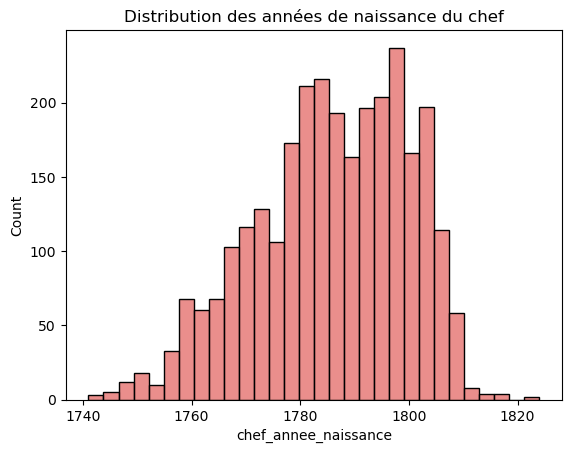

In [41]:
plt.title("Distribution des années de naissance du chef")
sns.histplot(data=df_new, x="chef_annee_naissance", bins=30, color="#e36866")

On effectue du bootstrap pour avoir une estimation de la moyenne et avoir un intervalle de confiance.

In [42]:
# Bootstrap the mean of the chef_annee_naissance column with 10_000 samples
means = []
for i in range(10_000):
    sample = df_new.chef_annee_naissance.sample(frac=1, replace=True)
    means.append(sample.mean())

In [43]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])
ci

array([1785.3035379 , 1786.33380563])

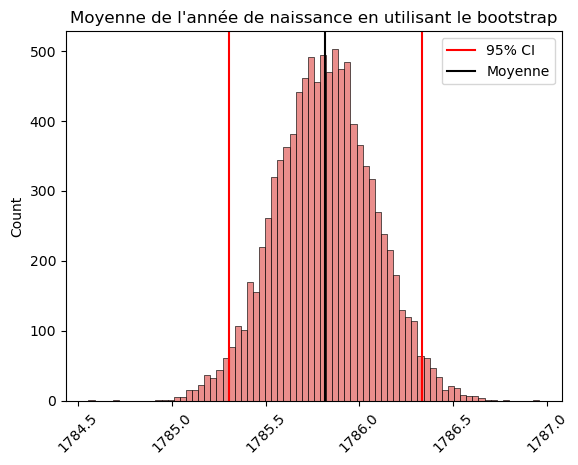

In [44]:
# plot the means with the 95% confidence interval
plt.title("Moyenne de l'année de naissance en utilisant le bootstrap")
sns.histplot(means, color="#e36866")
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.xticks(rotation=45)
plt.axvline(np.mean(means), color="black", label=f"Moyenne")
plt.legend()
plt.show()

In [45]:
# indicate the mean year of birth of the chef de famille with the 95% confidence interval
print(f"La moyenne des années de naissance des chefs de famille est de {np.mean(means):.2f} avec un intervalle de confiance de 95% de {ci[0]:.2f} à {ci[1]:.2f}.")
print(f"Cela s'écrirait donc {np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne des années de naissance des chefs de famille est de 1785.82 avec un intervalle de confiance de 95% de 1785.30 à 1786.33.
Cela s'écrirait donc 1785.8 ± 0.5.


In [46]:
# The mean age of the chef de famille
print(f"La moyenne d'âge des chefs de famille est de {1832 - np.mean(means):.2f} avec un intervalle de confiance de 95% de {1832 - ci[0]:.2f} à {1832 - ci[1]:.2f}.")
print(f"Cela s'écrirait donc {1832 - np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne d'âge des chefs de famille est de 46.18 avec un intervalle de confiance de 95% de 46.70 à 45.67.
Cela s'écrirait donc 46.2 ± 0.5.


In [47]:
df_new.chef_annee_naissance.min(), df_new.chef_annee_naissance.max()

(1741, 1824)

In [48]:
# std of the chef_annee_naissance column
df_new.chef_annee_naissance.std()

14.05622982538033

In [49]:
df_new.chef_annee_naissance.describe()

count    2876.000000
mean     1785.815021
std        14.056230
min      1741.000000
25%      1776.000000
50%      1787.000000
75%      1797.000000
max      1824.000000
Name: chef_annee_naissance, dtype: float64

In [50]:
(1832 - df_new.chef_annee_naissance).describe()

count    2876.000000
mean       46.184979
std        14.056230
min         8.000000
25%        35.000000
50%        45.000000
75%        56.000000
max        91.000000
Name: chef_annee_naissance, dtype: float64

#### La même mais pour les épouses

In [197]:
df_epouses = df[df.epouse_annee_naissance.str.len() == 4]
df_epouses = df_epouses[df_epouses.epouse_annee_naissance.str.isnumeric()]
df_epouses.epouse_annee_naissance = df_epouses.epouse_annee_naissance.astype(int)

In [198]:
df_epouses.shape[0] / df.shape[0]

0.6488840500816548

In [200]:
df_epouses = df_epouses[(df_epouses.epouse_annee_naissance < 1832) & (df_epouses.epouse_annee_naissance >= 1732)]
print(f"Ratio of values that we keep {df_epouses.shape[0] / df.shape[0]:%}, number of values that we keep is {df_epouses.shape[0]}.")

Ratio of values that we keep 64.289603%, number of values that we keep is 2362.


On a un pourcentage plus bas que celui des chefs de familles. Ceci est dû au fait que chaque chef de famille n'a pas forcément d'épouse.

<AxesSubplot:title={'center':"Distribution des années de naissance de l'épouse"}, xlabel='epouse_annee_naissance', ylabel='Count'>

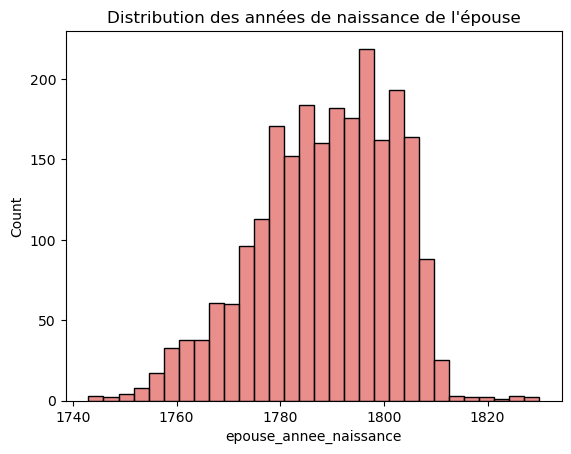

In [204]:
plt.title("Distribution des années de naissance de l'épouse")
sns.histplot(data=df_epouses, x="epouse_annee_naissance", bins=30, color="#e36866")

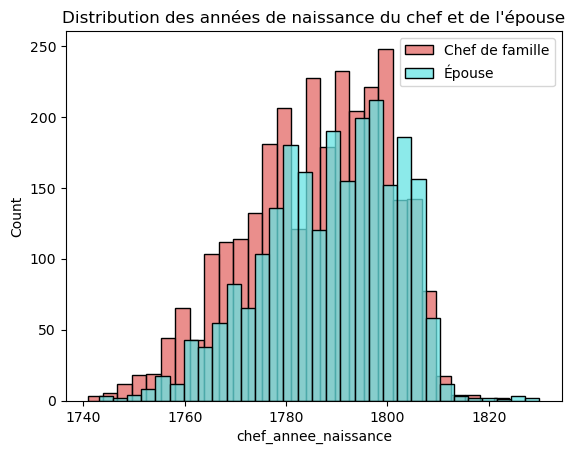

In [206]:
# plot the above two distributions on the same plot
plt.title("Distribution des années de naissance du chef et de l'épouse")
sns.histplot(data=df_new, x="chef_annee_naissance", color="#e36866", label="Chef de famille")
sns.histplot(data=df_epouses, x="epouse_annee_naissance", color="#66e3e3", label="Épouse")
plt.legend()
plt.show()

In [207]:
# Bootstrap the mean of the epouse_annee_naissance column with 10_000 samples 
means = []
for i in range(10_000):
    sample = df_epouses.epouse_annee_naissance.sample(frac=1, replace=True)
    means.append(sample.mean())

In [208]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])
ci

array([1788.17272439, 1789.23881245])

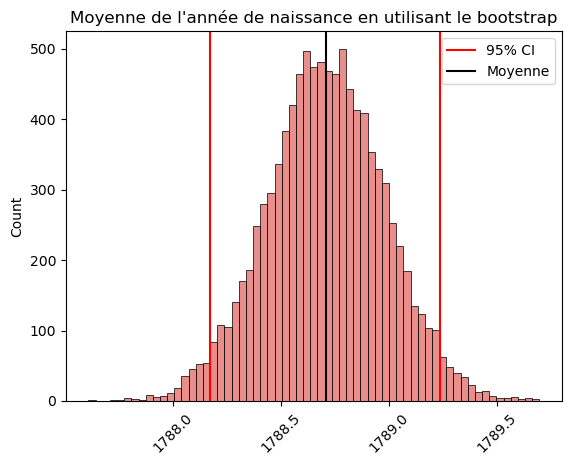

In [209]:
# plot the means with the 95% confidence interval
plt.title("Moyenne de l'année de naissance en utilisant le bootstrap")
sns.histplot(means, color="#e36866")
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.xticks(rotation=45)
plt.axvline(np.mean(means), color="black", label=f"Moyenne")
plt.legend()
plt.show()

In [210]:
# indicate the mean year of birth of the epouse with the 95% confidence interval
print(f"La moyenne des années de naissance des épouses est de {np.mean(means):.2f} avec un intervalle de confiance de 95% de {ci[0]:.2f} à {ci[1]:.2f}.")
print(f"Cela s'écrirait donc {np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne des années de naissance des épouses est de 1788.71 avec un intervalle de confiance de 95% de 1788.17 à 1789.24.
Cela s'écrirait donc 1788.7 ± 0.5.


In [211]:
# The mean age of the epouse
print(f"La moyenne d'âge des épouses est de {1832 - np.mean(means):.2f} avec un intervalle de confiance de 95% de {1832 - ci[0]:.2f} à {1832 - ci[1]:.2f}.")
print(f"Cela s'écrirait donc {1832 - np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne d'âge des épouses est de 43.29 avec un intervalle de confiance de 95% de 43.83 à 42.76.
Cela s'écrirait donc 43.3 ± 0.5.


## autres

In [51]:
# Bootstrap the mean of the chef_annee_naissance that have "administration" as chef_vocation_class with 10_000 samples
means_administration = []
for i in range(10_000):
    sample = df_new[df_new.chef_vocation_class == "administration"].chef_annee_naissance.sample(frac=1, replace=True)
    means_administration.append(sample.mean())
    
# Bootstrap the mean of the chef_annee_naissance that have "construction" as chef_vocation_class with 10_000 samples
means_construction = []
for i in range(10_000):
    sample = df_new[df_new.chef_vocation_class == "construction"].chef_annee_naissance.sample(frac=1, replace=True)
    means_construction.append(sample.mean())

<AxesSubplot:ylabel='Count'>

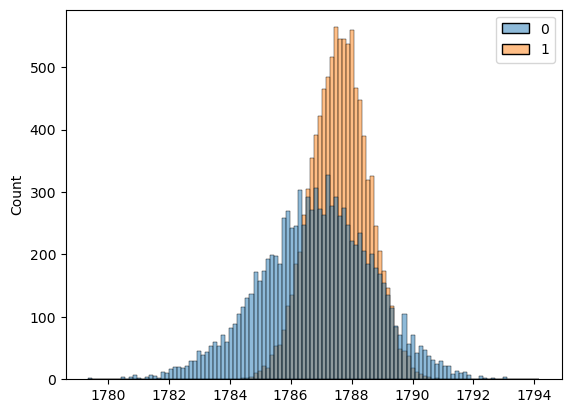

In [52]:
sns.histplot([means_administration, means_construction])

<AxesSubplot:xlabel='chef_annee_naissance', ylabel='Count'>

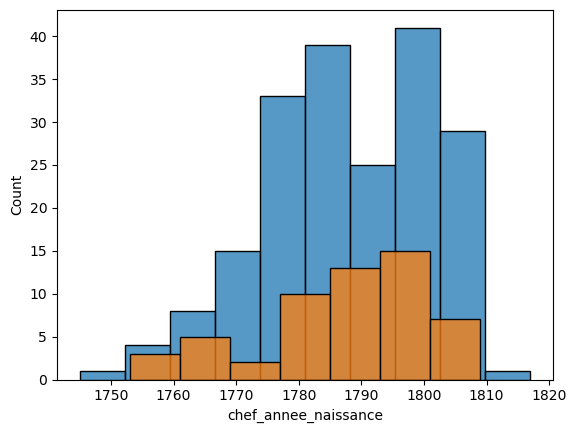

In [53]:
sns.histplot(df_new[df_new.chef_vocation_class == "construction"].chef_annee_naissance, label="construction")
sns.histplot(df_new[df_new.chef_vocation_class == "administration"].chef_annee_naissance, label="administration")

In [54]:
(1832 - df_new[df_new.chef_vocation_class == "administration"].chef_annee_naissance.mean(), 1832 - df_new[df_new.chef_vocation_class == "construction"].chef_annee_naissance.mean())

(45.16363636363644, 44.37755102040819)

In [55]:
df_new

,nom_rue,no_maison,proprietaire_nom,chef_prenom,chef_nom,chef_annee_naissance,epouse_nom,epouse_annee_naissance,enfants_dans_la_commune_prenom,enfants_annee_naissance,chef_origine,chef_annee_arrivee,chef_vocation,pensionnaires_prenom,pensionnaires_nom,pensionnaires_origine,Page,chef_vocation_class
1,marterey,1,weidmann,georges henri,weidmann,1764,·,·,·,·,tolochenaz,1786,charon,louise|anna|francois|jn adam,weidmann|la maurer|kirsner|reverber,tolochenaz|frutigen|cirol|bavarois,1,NaN
3,marterey,3,fiaux,louise,piot,1785,neissance,·,benjamin,1815,pailly,nee,lingere,·,·,·,1,service
5,marterey,·,fiaux,louis vincent,lavanchy,1802,baudet,1805,·,·,lutry,ne,garcon voiturier,·,·,·,1,NaN
7,marterey,·,fiaux,dominique,dubois,1797,·,·,·,·,nancy,1828,ebeniste,adolphine cecile|adolphine,borrely|borrely,paris|enfant de la che,1,NaN
8,marterey,·,fiaux,francois,fiaux,1787,blaud,·,felix|charles|ernestine,1826|·|1822,lausanne,ne,rentier,rose marie,metraux,pailly,1,rente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697,montheron,·,martin,jean abraham,martin,1804,francoise,1804,henry|david,1829|1830,froideville,·,agriculteur,·,·,·,150,agricole
3698,montheron,·,martin,jean abram,blanc,1806,marie,1807,charles elie|louis jules,1829|1831,lausanne,1830,journalier,·,·,·,151,agricole
3699,les saugealles,·,commune de lausanne,veuve,tuller,1810,·,neene,jn louise|lse susanne|jean marc|jaques|ct fran...,1800|1803|1806|1808|1809|1812|1814,gessenay,1820,agriculteur,·,·,·,151,agricole
3700,chalet aux enfants,·,auberjonois,david,zbinden,1771,francoise,1773,·,·,guggisberg,·,agriculteur,·,·,·,151,agricole


In [56]:
df_new.describe()

,chef_annee_naissance,Page
count,2876.000000,2876.000000
mean,1785.815021,75.590751
std,14.056230,41.516083
min,1741.000000,1.000000
25%,1776.000000,42.000000
50%,1787.000000,77.000000
75%,1797.000000,109.000000
max,1824.000000,151.000000


In [57]:
df_new[df_new.chef_annee_naissance == 1824]

,nom_rue,no_maison,proprietaire_nom,chef_prenom,chef_nom,chef_annee_naissance,epouse_nom,epouse_annee_naissance,enfants_dans_la_commune_prenom,enfants_annee_naissance,chef_origine,chef_annee_arrivee,chef_vocation,pensionnaires_prenom,pensionnaires_nom,pensionnaires_origine,Page,chef_vocation_class
563,cheneau de bourg,·,maget,jean david,martin,1824,coulin,1804,francois|emmanuel,1828|1830,villeneuve,·,tanneur,louise,maillari,perey,22,artisanat


Find the proprietary that comes up the most frequently.

In [58]:
df_new.groupby("proprietaire_nom").size().sort_values(ascending=False)

proprietaire_nom
blanc             59
perrin            49
corbaz            46
regamey           40
martin            32
                  ..
decoppet           1
decombaz           1
de treytorrens     1
peyrollaz          1
pittet             1
Length: 597, dtype: int64

## Statistiques sur le nombre d'enfants par famille

In [74]:
df.shape

(3674, 19)

On reprend toute la base de données (les 3674 entrées).

Les entrées sont de la forme suivante:
```
Alice|Bob
·
·
Charlie|Dan|Eve
Trudy|·|·|Mallor
```

In [83]:
def count_person(s: str) -> int:
    if s == '·' or s == '.':
        return 0
    return s.count("|") + 1

In [84]:
df["nb_enfants"] = df.enfants_dans_la_commune_prenom.apply(count_person)

In [85]:
df.nb_enfants.describe()

count    3674.000000
mean        1.443658
std         1.655033
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: nb_enfants, dtype: float64

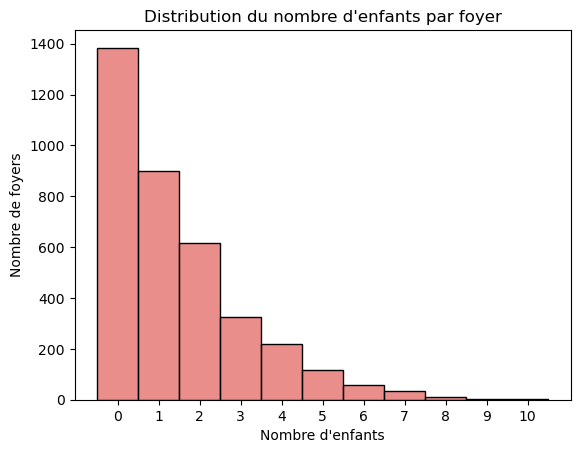

In [106]:
plt.title("Distribution du nombre d'enfants par foyer")
sns.histplot(data=df, x="nb_enfants", discrete=True, color="#e36866")
plt.ylabel("Nombre de foyers")
plt.xlabel("Nombre d'enfants")
plt.xticks(range(0, 11))
plt.show()

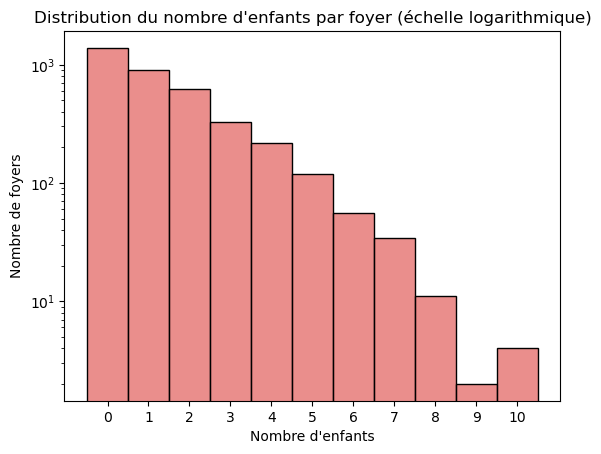

In [103]:
plt.title("Distribution du nombre d'enfants par foyer (échelle logarithmique)")
sns.histplot(data=df, x="nb_enfants", discrete=True, color="#e36866")
plt.ylabel("Nombre de foyers")
plt.xlabel("Nombre d'enfants")
plt.yscale("log")
plt.xticks(range(0, 11))
plt.show()

On peut voir que la distribution du nombre d'enfants par famille suis une loi exponentielle (la distribution est linéaire lorsqu'on la montre avec une échelle logarithmique).

In [107]:
# Bootstrap the mean of the nb_enfants column with 10_000 samples
means = []
for i in range(10_000):
    sample = df.nb_enfants.sample(frac=1, replace=True)
    means.append(sample.mean())

In [108]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])
ci

array([1.39003811, 1.49701279])

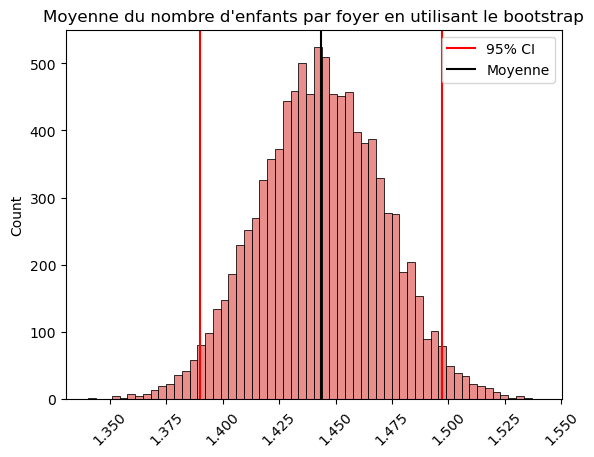

In [109]:
# plot the means with the 95% confidence interval
plt.title("Moyenne du nombre d'enfants par foyer en utilisant le bootstrap")
sns.histplot(means, color="#e36866")
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.xticks(rotation=45)
plt.axvline(np.mean(means), color="black", label=f"Moyenne")
plt.legend()
plt.show()

In [110]:
# indicate the mean year of birth of the chef de famille with the 95% confidence interval
print(f"La moyenne du nombre d'enfants par foyer est de {np.mean(means):.2f} avec un intervalle de confiance de 95% de {ci[0]:.2f} à {ci[1]:.2f}.")
print(f"Cela s'écrirait donc {np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne du nombre d'enfants par foyer est de 1.44 avec un intervalle de confiance de 95% de 1.39 à 1.50.
Cela s'écrirait donc 1.4 ± 0.1.


<AxesSubplot:title={'center':"Corrélation entre le nombre d'enfants et le nombre de pensionnaires"}>

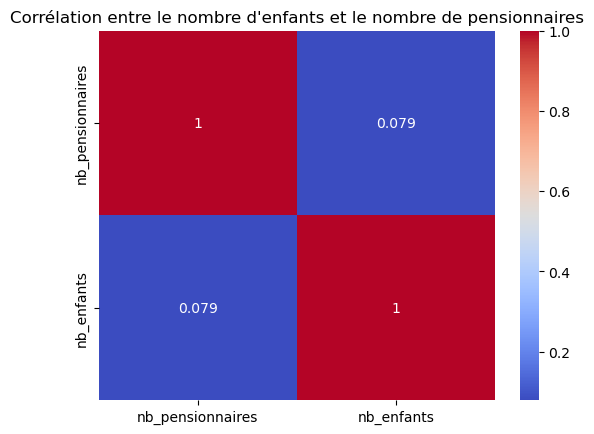

In [191]:
# Find the correlation between the number of people and the number of children
# plot it with a heatmap with values in the cells
corr = df[["nb_pensionnaires", "nb_enfants"]].corr()
plt.title("Corrélation entre le nombre d'enfants et le nombre de pensionnaires")
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

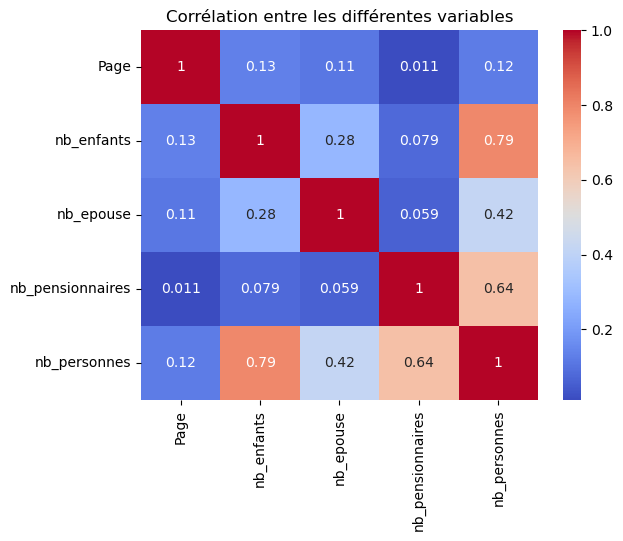

In [212]:
# heatmap of all the numerical columns
corr = df.corr()
plt.title("Corrélation entre les différentes variables")
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

## Nombre de personnes par famille

Pour ce faire, on utiliser l'épouse, les enfants et les pensionnaires.

In [113]:
df["nb_epouse"] = df.epouse_nom.apply(count_person)
df["nb_pensionnaires"] = df.pensionnaires_nom.apply(count_person)

In [114]:
df["nb_personnes"] = df.nb_enfants + df.nb_epouse + df.nb_pensionnaires + 1

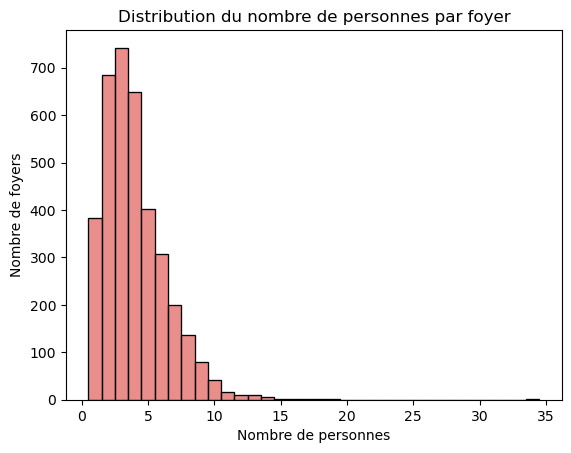

In [115]:
# Plot the distribution of the number of people per household
plt.title("Distribution du nombre de personnes par foyer")
sns.histplot(data=df, x="nb_personnes", discrete=True, color="#e36866")
plt.ylabel("Nombre de foyers")
plt.xlabel("Nombre de personnes")
plt.show()

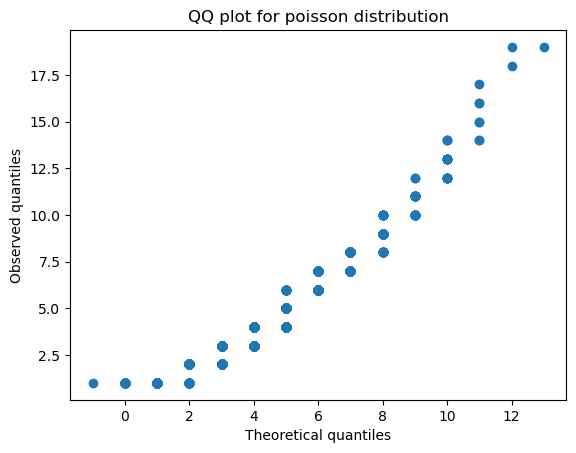

In [187]:
stats.kstest(np.random.normal(size=1000), stats.normaltest).pvalue
from scipy.stats import laplace, poisson, uniform, binom

func = poisson
## plot qqplot for list_coeff laplacian distribution
plt.figure()
plt.title(f'QQ plot for poisson distribution')
plt.ylabel('Observed quantiles')
plt.xlabel('Theoretical quantiles')

theoretical_quantiles = func.ppf(np.linspace(0, 1, len(df.nb_personnes)), mu=df.nb_personnes.mean())
observed_quantiles = np.sort(df.nb_personnes)
plt.plot(theoretical_quantiles, observed_quantiles, 'o')

In [192]:
# Bootstrap the mean of the nb_personnes column with 10_000 samples
means = []
for i in range(10_000):
    sample = df.nb_personnes.sample(frac=1, replace=True)
    means.append(sample.mean())

In [193]:
# Compute the 95% confidence interval of the mean
ci = np.quantile(means, [0.025, 0.975])
ci

array([3.92188351, 4.07512248])

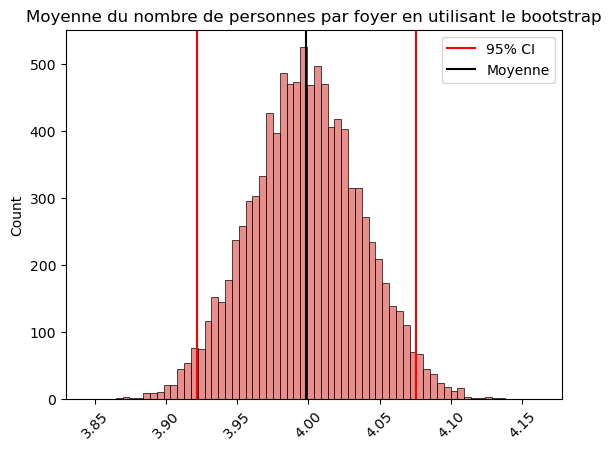

In [194]:
# plot the means with the 95% confidence interval
plt.title("Moyenne du nombre de personnes par foyer en utilisant le bootstrap")
sns.histplot(means, color="#e36866")
plt.axvline(ci[0], color="red", label="95% CI")
plt.axvline(ci[1], color="red")
plt.legend()
plt.xticks(rotation=45)
plt.axvline(np.mean(means), color="black", label=f"Moyenne")
plt.legend()
plt.show()

In [196]:
# Indicate the mean number of person per household with the 95% confidence interval
print(f"La moyenne du nombre de personnes par foyer est de {np.mean(means):.2f} avec un intervalle de confiance de 95% de {ci[0]:.2f} à {ci[1]:.2f}.")
print(f"Cela s'écrirait donc {np.mean(means):.1f} ± {np.mean(means) - ci[0]:.1f}.")

La moyenne du nombre de personnes par foyer est de 4.00 avec un intervalle de confiance de 95% de 3.92 à 4.08.
Cela s'écrirait donc 4.0 ± 0.1.
